In [26]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

In [29]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torchvision.transforms as T
from PIL import Image

# Новый раздел

# аугментация данных

Применяются только аугментации отзеркаливания, зума и поворотов так как изменение насыщенности или формы может сделать гистограмму похожей на другой тип ткани

In [30]:
from torchvision.transforms import v2, functional

def random_augment(img):
    _, h, w = img.shape
    choice = random.randint(0, 3)

    if choice == 0:
        return F.hflip(img)

    elif choice == 1:
        return F.vflip(img)

    elif choice == 2:  # Zoom
        scale = random.uniform(0.9, 1.1)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = F.resize(img, (new_h, new_w), interpolation=F.InterpolationMode.BILINEAR)

        if scale > 1.0:
            top = (new_h - h) // 2
            left = (new_w - w) // 2
            return F.crop(resized, top, left, h, w)
        else:
            pad_top = (h - new_h) // 2
            pad_bottom = h - new_h - pad_top
            pad_left = (w - new_w) // 2
            pad_right = w - new_w - pad_left
            padding = (pad_left, pad_right, pad_top, pad_bottom)
            return F.pad(resized, padding, padding_mode='reflect')

    elif choice == 3:  # rotation
        angle = random.uniform(-10, 10)
        rotated = F.rotate(img, angle, expand=True, interpolation=F.InterpolationMode.BILINEAR)
        _, new_h, new_w = rotated.shape

        if new_h < h or new_w < w:
            pad_top = (h - new_h) // 2
            pad_bottom = h - new_h - pad_top
            pad_left = (w - new_w) // 2
            pad_right = w - new_w - pad_left
            padding = (pad_left, pad_right, pad_top, pad_bottom)
            return F.pad(rotated, padding, padding_mode='reflect')

        top = (new_h - h) // 2
        left = (new_w - w) // 2
        return F.crop(rotated, top, left, h, w)

In [31]:
import os
class Dataset:

    def __init__(self, name, local_path = None):
        self.name = name
        self.is_loaded = False

        if local_path is not None:
            # Use uploaded/local file
            if not os.path.exists(local_path):
                raise FileNotFoundError(f"Local dataset file not found: {local_path}")
            output_path = local_path
            print(f'Loading dataset {self.name} from local file: {local_path}')
        else:
            # Download from Google Drive
            drive_id = DATASETS_LINKS.get(name)
            if not drive_id:
                raise ValueError(f"Dataset '{name}' not found in DATASETS_LINKS.")
            url = f"https://drive.google.com/uc?id={drive_id}"
            output_path = f'{name}.npz'
            if not os.path.exists(output_path):
                print(f"Downloading dataset {name} from Google Drive...")
                gdown.download(url, output_path, quiet=False)
            else:
                print(f"Dataset {name} already exists locally. Skipping download.")

        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(output_path)
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [32]:
import random

class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            #img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor

            if random.random() < 0.4:
                img = random_augment(img)

            return img, label

In [33]:
"""
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))
"""

'\nif "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:\n    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")\nelse:\n    print("Пример использования PyTorch-обёртки над Dataset")\n\n    base_train = Dataset(\'train_tiny\')\n\n    # Создаём PyTorch-совместимый датасет\n    train_ds = HistologyTorchDataset(base_train)\n\n    # DataLoader автоматически создаёт батчи и перемешивает данные\n    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)\n\n    # Берём один батч и выводим информацию\n    images_batch, labels_batch = next(iter(train_loader))\n\n    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]\n    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]\n    print("Пример меток:", labels_batch[:10].tolist())\n\n    print("Тип images_batch:", type(images_batch))\n    print("Тип labels_batch:", type(labels_batch))\n'

**Метрики**

In [34]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

# Модель

In [35]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.num_classes = len(TISSUE_CLASSES)

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, self.num_classes)

    def forward(self, x):
        x = self.enc1(x)
        x = self.pool1(x)

        x = self.enc2(x)
        x = self.pool2(x)

        x = self.bottleneck(x)

        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.fc(x)

        return x

    def save_weights(self, path):
        torch.save(self.state_dict(), path)

    def load_weights(self, path, device=None):
        self.load_state_dict(torch.load(path, map_location=device))

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img):
        # todo: replace this code
        prediction = self.forward(img)
        return prediction

# Валидация на всей эпохе

In [36]:
def validate(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return Metrics.accuracy(all_labels, all_preds), Metrics.accuracy_balanced(all_labels, all_preds)

In [69]:
import datetime

def write_to_log(str_content):
    current_datetime = datetime.datetime.now()
    datetime_str = current_datetime.strftime("%d-%m_%H-%M")

    filename = f"log_{datetime_str}.txt"

    with open(filename, 'w', encoding='utf-8') as file:
        file.write(str_content)

    print(f"Successfully wrote to {filename}")
    return os.path.abspath(filename)

In [38]:
#write_to_log("test")

# функция обучения

In [70]:
import copy
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_with_early_stopping(
        model_class,
        train_loader,
        val_loader,
        device,
        max_epochs=50,
        patience=5,
        LOAD_FROM_CHECKPOINT=False):



    best_acc = 0
    best_b_acc = 0
    epochs_no_improve = 0
    best_epoch = 0
    best_model_w = None

    LR = 2e-4

    model = model_class().to(device)

    if LOAD_FROM_CHECKPOINT:
        try:
            model.load_weights('best_model.pth', device)
        except:
            print("LOADING FAILED")
            exit(0)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    val_balanced_accuracies = []

    log_str = f'learning started: max epochs = {max_epochs}, patience = {patience}, Learning rate = {LR}\n\n'



    for epoch in range(max_epochs):
        model.train()
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=False)

        epoch_loss = 0.0
        correct_train = 0
        total_train = 0


        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        val_acc, val_acc_b = validate(model, val_loader, device)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_balanced_accuracies.append(val_acc_b)

        str = f"Epoch {epoch + 1} - Val Acc: {val_acc:.4f} Val_acc_b: {val_acc_b}"
        tqdm.write(str)
        log_str += str

        if (val_acc > best_acc):
            best_acc = val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            best_model_w = copy.deepcopy(model.state_dict())
            str = f"Improvement detected (acc: {val_acc:.4f} acc_balanced: {val_acc_b:.4f}| Final {best_acc:.4f})"
            tqdm.write(str)
            log_str += str

            torch.save(best_model_w, "best_model.pth")
        else:
            epochs_no_improve += 1

        if epochs_no_improve > patience:
            tqdm.write("the end")
            break

    if best_model_w is not None:
        model.load_state_dict(best_model_w)

    str = (f'best result is {best_acc} best epoch is {epoch + 1}')
    tqdm.write(str)
    log_str += str

    epochs_trained = len(train_losses)
    plt.figure(figsize=(12, 4))

    # Plot 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses, label='Train Loss', color='tab:red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    # Plot 2: Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies, label='Train Acc', marker='o')
    plt.plot(range(1, epochs_trained + 1), val_accuracies, label='Val Acc', marker='s')
    plt.plot(range(1, epochs_trained + 1), val_balanced_accuracies, label='Val Acc (Balanced)', linestyle='--', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.suptitle(f'Training Summary (Best Val Acc: {best_acc:.4f} @ Epoch {best_epoch + 1})', y=1.02)
    plt.savefig("training_curve.png", dpi=150, bbox_inches='tight')
    plt.show(block=False)

    write_to_log(log_str)

    return model


#**Main part**


**Грузим датасет по ссылке**

In [64]:
from torch.utils.data import random_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = HistologyTorchDataset(Dataset('train'))

Downloading...
From (original): https://drive.google.com/uc?id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
From (redirected): https://drive.google.com/uc?id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi&confirm=t&uuid=c5fc368e-af53-4f5c-933c-2ae66da54281
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:33<00:00, 62.3MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Создаем даталоадеры с валидацией (20 процентов от тренировачного набора)

In [71]:
BATCH_SIZE = 64
#except:
#    print("fail")
#    from google.colab import files
#    uploaded = files.upload()
#    from google.colab import files
 #   uploaded = files.upload()
 #   train_dataset = HistologyTorchDataset(Dataset(name="train_small", local_path="train_small.npz"))

dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, persistent_workers=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### **Обучение с ранней остановкой и чекпоинтами**

In [42]:
LOAD_CHECKPOINT = False

**Можно использовать эту переменную если нужно воостановить веса после прерывания обучения**

Epoch 1/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 1 - Val Acc: 0.7392 Val_acc_b: 0.7367421349275839
Improvement detected (acc: 0.7392 acc_balanced: 0.7367| Final 0.7392)


Epoch 2/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 2 - Val Acc: 0.7438 Val_acc_b: 0.7396536029915267
Improvement detected (acc: 0.7438 acc_balanced: 0.7397| Final 0.7438)


Epoch 3/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 3 - Val Acc: 0.7726 Val_acc_b: 0.7731543377543579
Improvement detected (acc: 0.7726 acc_balanced: 0.7732| Final 0.7726)


Epoch 4/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 4 - Val Acc: 0.8653 Val_acc_b: 0.8628176242544281
Improvement detected (acc: 0.8653 acc_balanced: 0.8628| Final 0.8653)


Epoch 5/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 5 - Val Acc: 0.8847 Val_acc_b: 0.8826261569027549
Improvement detected (acc: 0.8847 acc_balanced: 0.8826| Final 0.8847)


Epoch 6/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 6 - Val Acc: 0.9191 Val_acc_b: 0.9192434389272849
Improvement detected (acc: 0.9191 acc_balanced: 0.9192| Final 0.9191)


Epoch 7/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 7 - Val Acc: 0.8108 Val_acc_b: 0.8055822644364042


Epoch 8/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 8 - Val Acc: 0.8507 Val_acc_b: 0.8529010335402742


Epoch 9/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 9 - Val Acc: 0.8677 Val_acc_b: 0.8678084359711057


Epoch 10/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 10 - Val Acc: 0.8986 Val_acc_b: 0.8985467430141445


Epoch 11/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 11 - Val Acc: 0.9087 Val_acc_b: 0.9082568806856841


Epoch 12/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 12 - Val Acc: 0.9313 Val_acc_b: 0.9310237189807897
Improvement detected (acc: 0.9313 acc_balanced: 0.9310| Final 0.9313)


Epoch 13/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 13 - Val Acc: 0.9010 Val_acc_b: 0.9021938700154222


Epoch 14/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 14 - Val Acc: 0.9125 Val_acc_b: 0.9115258218168422


Epoch 15/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 15 - Val Acc: 0.9198 Val_acc_b: 0.9208725999838305


Epoch 16/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 16 - Val Acc: 0.9608 Val_acc_b: 0.9611604489556826
Improvement detected (acc: 0.9608 acc_balanced: 0.9612| Final 0.9608)


Epoch 17/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 17 - Val Acc: 0.9403 Val_acc_b: 0.9406087475546894


Epoch 18/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 18 - Val Acc: 0.8243 Val_acc_b: 0.8270121624159281


Epoch 19/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 19 - Val Acc: 0.8562 Val_acc_b: 0.8569720735579859


Epoch 20/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 20 - Val Acc: 0.8924 Val_acc_b: 0.8928089042910917


Epoch 21/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 21 - Val Acc: 0.9524 Val_acc_b: 0.9523462246717289


Epoch 22/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 22 - Val Acc: 0.9604 Val_acc_b: 0.9593157878662097


Epoch 23/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 23 - Val Acc: 0.9059 Val_acc_b: 0.9068469747241795


Epoch 24/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 24 - Val Acc: 0.9424 Val_acc_b: 0.9427805767460998


Epoch 25/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 25 - Val Acc: 0.9524 Val_acc_b: 0.9519629748292502


Epoch 26/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 26 - Val Acc: 0.9458 Val_acc_b: 0.9460102337109814


Epoch 27/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 27 - Val Acc: 0.8344 Val_acc_b: 0.8338517988418097


Epoch 28/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 28 - Val Acc: 0.9708 Val_acc_b: 0.9709307353255267
Improvement detected (acc: 0.9708 acc_balanced: 0.9709| Final 0.9708)


Epoch 29/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 29 - Val Acc: 0.8344 Val_acc_b: 0.8348445624574677


Epoch 30/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 30 - Val Acc: 0.8872 Val_acc_b: 0.8874236128542818


Epoch 31/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 31 - Val Acc: 0.9552 Val_acc_b: 0.9549138467531244


Epoch 32/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 32 - Val Acc: 0.9253 Val_acc_b: 0.9252074277377338


Epoch 33/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 33 - Val Acc: 0.8861 Val_acc_b: 0.8860240808977395


Epoch 34/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 34 - Val Acc: 0.9601 Val_acc_b: 0.9603321822881726


Epoch 35/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 35 - Val Acc: 0.8847 Val_acc_b: 0.885091385366734


Epoch 36/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 36 - Val Acc: 0.9625 Val_acc_b: 0.9625632285570531


Epoch 37/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 37 - Val Acc: 0.9444 Val_acc_b: 0.9450077517769377


Epoch 38/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 38 - Val Acc: 0.9698 Val_acc_b: 0.9697921986812406


Epoch 39/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 39 - Val Acc: 0.9003 Val_acc_b: 0.8998540142511009


Epoch 40/40:   0%|          | 0/180 [00:00<?, ?it/s]

Epoch 40 - Val Acc: 0.9528 Val_acc_b: 0.9532055965892715
best result is 0.9708333333333333 best epoch is 40


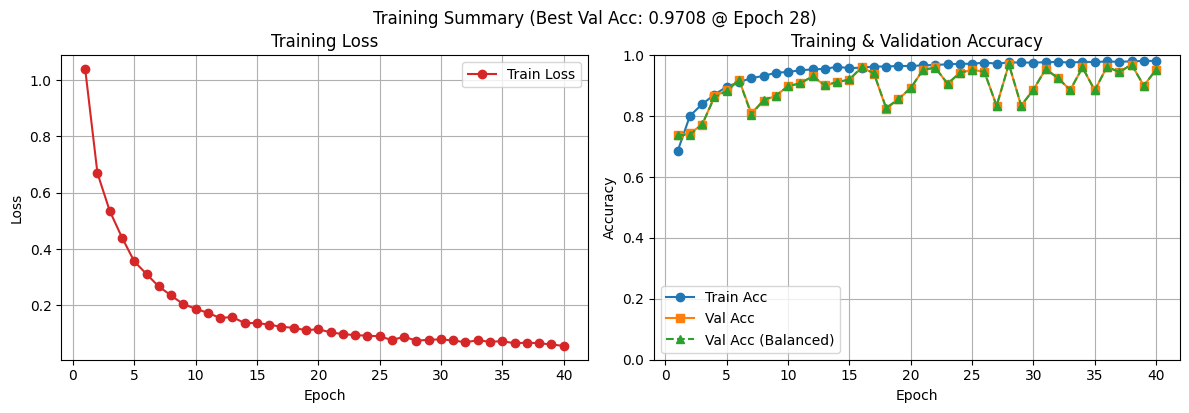

Successfully wrote to log_01-12_19-25.txt


In [72]:
model = train_with_early_stopping(LOAD_FROM_CHECKPOINT=LOAD_CHECKPOINT,
        model_class=Model,
        train_loader=train_loader,
        val_loader=val_loader,
        device= device,
        max_epochs=40,
        patience=12)

## Проверка на тестовой выборке

In [73]:
test_loader = DataLoader(HistologyTorchDataset(Dataset('test')))

validate(model, test_loader, device)

Dataset test already exists locally. Skipping download.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


(0.968, np.float64(0.968))